In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Open a console to this kernel
%qtconsole

# Use notebook style for graphs
%matplotlib notebook

## Define geography

Inflow data is given by EMPS model areas. Define here which EMPS areas belong to which [e-Highways](http://www.e-highway2050.eu/e-highway2050/) network nodes which we use in modelling. See image below. 
![](img/E-highway.png).

In [3]:
EMPS_AREAS_TO_NODES = {
                       # Norway
                       'OSTLAND': '82NO',
                       'SOROST': '82NO',
                       'HALLINGDAL': '80NO',
                       'TELEMARK': '80NO', 
                       'SORLAND': '79NO',
                       'VESTSYD': '79NO',
                       'VESTMIDT': '81NO',
                       'NORGEMIDT': '83NO',
                       'HELGELAND': '84NO',
                       'TROMS': '84NO',
                       'FINNMARK': '85NO',

                       # Sweden
                       'SVER-ON1':  '86SE',  # Upper North Sweden 1
                       'SVER-ON2':  '86SE',  # Upper North Sweden 2
                       'SVER-NN1':  '87SE',  # North Sweden 1
                       'SVER-NN2':  '87SE',  # North Sweden 2
                       'SVER-MIDT': '88SE',  # Middle Sweden
                       'SVER-SYD':  '89SE'   # South Sweden
                      }

## Load data

Load weekly inflow data for years 1958–2015. Source of data is SINTEF Energi AS. 

In [112]:
# A convenience function to load data in given columns
def load_data(columns):
    df = pd.read_excel(r"C:\DATA\Misc. data\NO+SE_inflow_1958-2015.xlsx", 
                         sheet_name='reg_ureg_nor_swe',
                         skiprows=3, usecols=columns)
    df.index = pd.MultiIndex.from_product([range(1958, 2016), range(1, 53)])
    df.index.names = ['year', 'week']
    return df

# Load data and select years 2012 and 2013
regulated_EMPS = load_data('A:Q').loc[2012:2013]
unregulated_EMPS = load_data('S:AI').loc[2012:2013]

Make a preview plot of data.

<IPython.core.display.Javascript object>


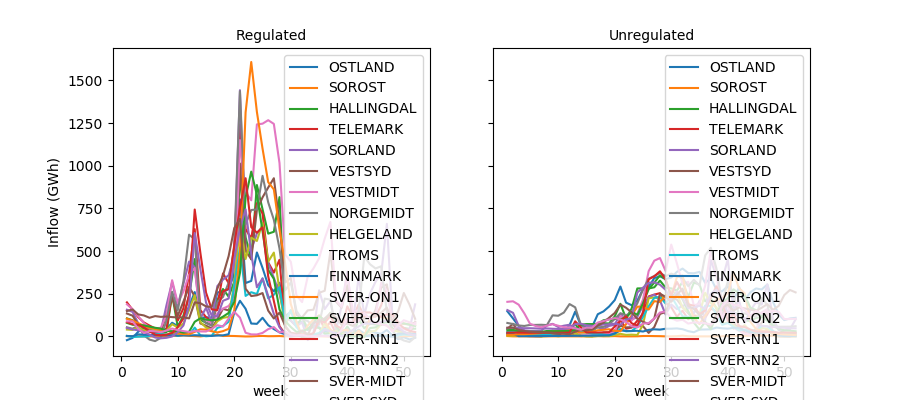

In [113]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9,4))
regulated_EMPS.loc[2012].plot(ax=ax1)
unregulated_EMPS.loc[2012].plot(ax=ax2)
ax1.set_title('Regulated');
ax1.set_ylabel('Inflow (GWh)');
ax2.set_title('Unregulated');
ax1.set_ylabel('Inflow (GWh)');

## Calculations

Group by network nodes and sum, also clip to positive values

In [52]:
regulated = regulated_EMPS.groupby(EMPS_AREAS_TO_NODES, axis=1).sum().clip(0)
unregulated = unregulated_EMPS.groupby(EMPS_AREAS_TO_NODES, axis=1).sum().clip(0)

Append 'Reservoir' to regulated node names and 'RoR' to unregulated. Then merge as one dataframe along columns axis.

In [53]:
regulated.columns = [node + '_Reservoir' for node in regulated.columns]
unregulated.columns = [node + '_RoR' for node in unregulated.columns]
inflow = pd.concat([regulated, unregulated], axis=1)

Interpolate to hourly frequency.

In [83]:
idx = pd.period_range('2012-01-01', freq='7D', periods=len(inflow.index))
inflow_hourly = (pd.DataFrame(inflow.values, index=idx, columns=inflow.columns)
      .resample('H').interpolate() / 168)  # Divide by 168 (hours in week)
inflow_hourly = df.loc[df.index.year == 2012]  # Only select year 2012

Calculate share of each hour to the the annual inflow.

In [88]:
inflow_profile = df / df.sum()

## Prepare for Backbone

Fill missing values with zeros.

In [119]:
df = inflow_profile.fillna(0)

Add columns for time labels (`tNNNNNN`) and forecast (`f00`) and use those as index.

In [120]:
df['t'] = [f't{t + 1:06d}' for t in range(len(df.index))]
df['f'] = 'f00'
df = df.set_index(['f', 't'])
df.head()

79NO_Reservoir  80NO_Reservoir  81NO_Reservoir  82NO_Reservoir  \
f   t                                                                         
f00 t000001        0.000067        0.000086        0.000061             0.0   
    t000002        0.000067        0.000086        0.000061             0.0   
    t000003        0.000067        0.000086        0.000061             0.0   
    t000004        0.000066        0.000086        0.000061             0.0   
    t000005        0.000066        0.000086        0.000061             0.0   

             83NO_Reservoir  84NO_Reservoir  85NO_Reservoir  86SE_Reservoir  \
f   t                                                                         
f00 t000001        0.000023        0.000026        0.000014        0.000059   
    t000002        0.000023        0.000026        0.000014        0.000059   
    t000003        0.000023        0.000026        0.000014        0.000059   
    t000004        0.000023        0.000026        0.000014        0.000058   
    t000005        0.000023        0.000026        0.000014        0.000058   

             87SE_Reservoir  88SE_Reservoir    ...     80NO_RoR  81NO_RoR  \
f   t                                          ...                          
f00 t000001         0.00005        0.000105    ...     0.000036  0.000039   
    t000002         0.00005        0.000105    ...     0.000036  0.000039   
    t000003         0.00005        0.000105    ...     0.000036  0.000039   
    t000004         0.00005        0.000105    ...     0.000036  0.000038   
    t000005         0.00005        0.000105    ...     0.000036  0.000038   

             82NO_RoR  83NO_RoR  84NO_RoR  85NO_RoR  86SE_RoR  87SE_RoR  \
f   t                                                                     
f00 t000001  0.000086   0.00005  0.000028  0.000087  0.000024  0.000037   
    t000002  0.000086   0.00005  0.000028  0.000087  0.000024  0.000037   
    t000003  0.000086   0.00005  0.000028  0.000087  0.000024  0.000037   
    t000004  0.000086   0.00005  0.000028  0.000087  0.000024  0.000037   
    t000005  0.000086   0.00005  0.000028  0.000087  0.000024  0.000037   

             88SE_RoR  89SE_RoR  
f   t                            
f00 t000001  0.000047  0.000219  
    t000002  0.000047  0.000219  
    t000003  0.000047  0.000219  
    t000004  0.000047  0.000220  
    t000005  0.000047  0.000220  

[5 rows x 22 columns]

In [121]:
df.columns = pd.MultiIndex.from_product([['water'], df.columns])
df.head()

water                                               \
            79NO_Reservoir 80NO_Reservoir 81NO_Reservoir 82NO_Reservoir   
f   t                                                                     
f00 t000001       0.000067       0.000086       0.000061            0.0   
    t000002       0.000067       0.000086       0.000061            0.0   
    t000003       0.000067       0.000086       0.000061            0.0   
    t000004       0.000066       0.000086       0.000061            0.0   
    t000005       0.000066       0.000086       0.000061            0.0   

                                                                         \
            83NO_Reservoir 84NO_Reservoir 85NO_Reservoir 86SE_Reservoir   
f   t                                                                     
f00 t000001       0.000023       0.000026       0.000014       0.000059   
    t000002       0.000023       0.000026       0.000014       0.000059   
    t000003       0.000023       0.000026       0.000014       0.000059   
    t000004       0.000023       0.000026       0.000014       0.000058   
    t000005       0.000023       0.000026       0.000014       0.000058   

                                             ...                         \
            87SE_Reservoir 88SE_Reservoir    ...     80NO_RoR  81NO_RoR   
f   t                                        ...                          
f00 t000001        0.00005       0.000105    ...     0.000036  0.000039   
    t000002        0.00005       0.000105    ...     0.000036  0.000039   
    t000003        0.00005       0.000105    ...     0.000036  0.000039   
    t000004        0.00005       0.000105    ...     0.000036  0.000038   
    t000005        0.00005       0.000105    ...     0.000036  0.000038   

                                                                        \
             82NO_RoR 83NO_RoR  84NO_RoR  85NO_RoR  86SE_RoR  87SE_RoR   
f   t                                                                    
f00 t000001  0.000086  0.00005  0.000028  0.000087  0.000024  0.000037   
    t000002  0.000086  0.00005  0.000028  0.000087  0.000024  0.000037   
    t000003  0.000086  0.00005  0.000028  0.000087  0.000024  0.000037   
    t000004  0.000086  0.00005  0.000028  0.000087  0.000024  0.000037   
    t000005  0.000086  0.00005  0.000028  0.000087  0.000024  0.000037   

                                 
             88SE_RoR  89SE_RoR  
f   t                            
f00 t000001  0.000047  0.000219  
    t000002  0.000047  0.000219  
    t000003  0.000047  0.000219  
    t000004  0.000047  0.000220  
    t000005  0.000047  0.000220  

[5 rows x 22 columns]

Pivot the table to make final data.

In [122]:
ts_influx = df.unstack([0,1])
ts_influx.head()

                       f    t      
water  79NO_Reservoir  f00  t000001    0.000067
                            t000002    0.000067
                            t000003    0.000067
                            t000004    0.000066
                            t000005    0.000066
dtype: float64

Write to a GDX file using `gdx2py`. 

In [117]:
from gdx2py import GdxFile

with GdxFile('inflow_NO+SE.gdx', 'w') as gdx:
    gdx['ts_influx'] = ts_influx